# On the occupation of hubs under different network processes

[Simon Dobson](mailto:simon.dobson@st-andrews.ac.uk) <br> School of Computer Science, University of St Andrews, Scotland UK

In [170]:
from epydemic import StochasticDynamics, Process, ProcessSequence, SIR, ERNetwork, PLCNetwork, Percolate
from epyc import Experiment, HDF5LabNotebook, ParallelLab
import numpy
from networkx import get_node_attributes, neighbors

# display and interaction
import matplotlib
%matplotlib inline
%config InlineBackend.figure_format = 'png'
matplotlib.rcParams['figure.dpi'] = 300
import matplotlib.pyplot as plt
import seaborn
matplotlib.style.use('seaborn')
seaborn.set_context('notebook', font_scale=0.75)

In [173]:
nb = HDF5LabNotebook('datasets/hub-occupancy.h5',
                     description='Occupancy of hubs under different network processes')
lab = ParallelLab(nb, cores=-4)

In [2]:
class PercolateWithOrder(Percolate):
    '''A percolation process that marks nodes with the order in which
    they are occupied, defined as the time at which an incident edge
    is occupied.'''
    
    OCCUPIED = 'epyemic.percolatewithorder.order'  #: Node attribute for order of occupation.
    
    def __init__(self):
        super().__init__()
        
    def occupy(self, occupied):
        '''Store the occupation order in the :self:`OCCUPIED` attribute
        at each node. This relies on the edges being passed in occupation
        order.
        
        :param occupied: ordered list of occupied edges'''
        g = self.network()
        t = 0        
        for (n, m) in occupied:
            if self.OCCUPIED not in g[n].keys():
                g[n][self.OCCUPIED] = t
                t += 1
            if self.OCCUPIED not in g[m].keys():
                g[m][self.OCCUPIED] = t
                t += 1                  

In [193]:
class SIRWithOrder(SIR):
    '''An SIR epidemic that marks nodes with the order of their infection starting
    from a single seed node.'''
    
    # Node attributes
    T_OCCUPIED = 'epydemic.SIRwithorder.t_occupied'    #: Node attribute for order of infection.
    
    # Experimental results
    DEGREE_DIST = 'epydemic.SIRwithorder.degree_dist'
    INFECTED_FRACTION = 'epydemic.SIRwithorder.infected_fraction'
    INFECTED_DEGREE_DIST = 'epydemic.SIRwithorder.infected_degree_dist'
    INFECTED_DEGREE_PASSAGE_TIME = 'epydemic.SIRwithorder.infected_degree_passage_time'
    
    def __init__(self):
        super().__init__()
        self._order = 0
        self._seed = None
        
    def initialCompartments(self):
        '''Replace random seeding of the network with choosing a
        single random node as the initial seed.'''
        g = self.network()
        ns = set(g.nodes())
        N = len(ns)
        
        # choose one node and infect it
        rng = numpy.random.default_rng()
        n = rng.integers(N)
        self.changeInitialCompartment(n, self.INFECTED)
        self._seed = n
        
        # mark all other nodes as susceptible
        ns.remove(n)
        for n in ns:
            self.changeInitialCompartment(n, self.SUSCEPTIBLE)

    def seed(self):
        '''Return the initially infected node.
        
        :returns: the seed node'''
        return self._seed
    
    def build(self, params):
        '''Build the network without any random infection
        
        :param params: the experimental parameters'''
        params[self.P_INFECTED] = 0.0
        super().build(params)
        self._order = 0
        self._seed = None
        
    def changeCompartment(self, n, c):
        '''Record that infection time of a node. This assumes that infection
        only happens once, which is true for SIR.
        
        :param n: the node
        :param c: the new compartment'''
        super().changeCompartment(n, c)
        if c == self.INFECTED:
            # record the infection time of the susceptible node
            g = self.network()
            g.nodes[n][self.T_OCCUPIED] = self._order
            self._order += 1
            
    def results(self):
        '''Compute the degree distribution histogram for the infected sub-network
        and the first passage times for nodes of different degrees.
        
        :returns: the results'''
        g = self.network()
        res = super().results()
        
        # compute the infected fraction 
        s = res[SIR.REMOVED] / g.order()
        res[self.INFECTED_FRACTION] = s
        
        # compute the degree histogram of the base and infected networks
        attrs = get_node_attributes(g, self.T_OCCUPIED)
        order = list(map(lambda p: p[0], sorted(list(attrs.items()), key=lambda p: p[1])))
        degs = list(map(lambda n: len(list(g.neighbors(n))), order))
        res[self.INFECTED_DEGREE_DIST] = degs
        rawdegs = list(map(lambda n: len(list(g.neighbors(n))), g.nodes()))
        res[self.DEGREE_DIST] = rawdegs

        # compute the first passage time for occupying nodes of a given degree
        kmax = max(degs)
        passage = [0] * (kmax + 1)
        for i in range(len(order)):
            k = rawdegs[i]
            if passage[k] == 0:
                # first node of this degree we've seen
                passage[k] = i
        res[self.INFECTED_DEGREE_PASSAGE_TIME] = passage
        
        return res

In [176]:
pInfect = 0.01
pRemove = 0.02

N = int(1e5)
kmean = 20

In [194]:
sir = SIRWithOrder()
fn = FinalNetwork()
p = ProcessSequence([sir, fn])

params = dict()
params[SIR.P_INFECT] = pInfect
params[SIR.P_REMOVE] = pRemove
params[ERNetwork.N] = N
params[ERNetwork.KMEAN] = kmean

e = StochasticDynamics(p, ERNetwork())
rc_er = e.set(params).run()

In [195]:
rc_er

{'parameters': {'epydemic.SIR.pInfect': 0.01,
  'epydemic.SIR.pRemove': 0.02,
  'epydemic.generators.ER.N': 100000,
  'epydemic.generators.ER.kmean': 20,
  'epydemic.SIR.pInfected': 0.0,
  'epydemic.generators.topology': 'ER'},
 'metadata': {'epyc.experiment.classname': 'epydemic.stochasticdynamics.StochasticDynamics',
  'epyc.experiment.start_time': datetime.datetime(2021, 5, 26, 14, 48, 28, 538730),
  'epyc.experiment.setup_time': 5.912361,
  'epydemic.Dynamics.time': 733.6157742624316,
  'epydemic.Dynamics.events': 199761,
  'epyc.experiment.experiment_time': 58.354927,
  'epyc.experiment.teardown_time': 0.120236,
  'epyc.experiment.end_time': datetime.datetime(2021, 5, 26, 14, 49, 32, 926254),
  'epyc.experiment.elapsed_time': 64.38752400000001,
  'epyc.experiment.status': True},
 'results': {'epydemic.SIR.S': 119,
  'epydemic.SIR.I': 0,
  'epydemic.SIR.R': 99881,
  'epydemic.SIRwithorder.infected_fraction': 0.99881,
  'epydemic.SIRwithorder.infected_degree_dist': [14,
   34,
   30

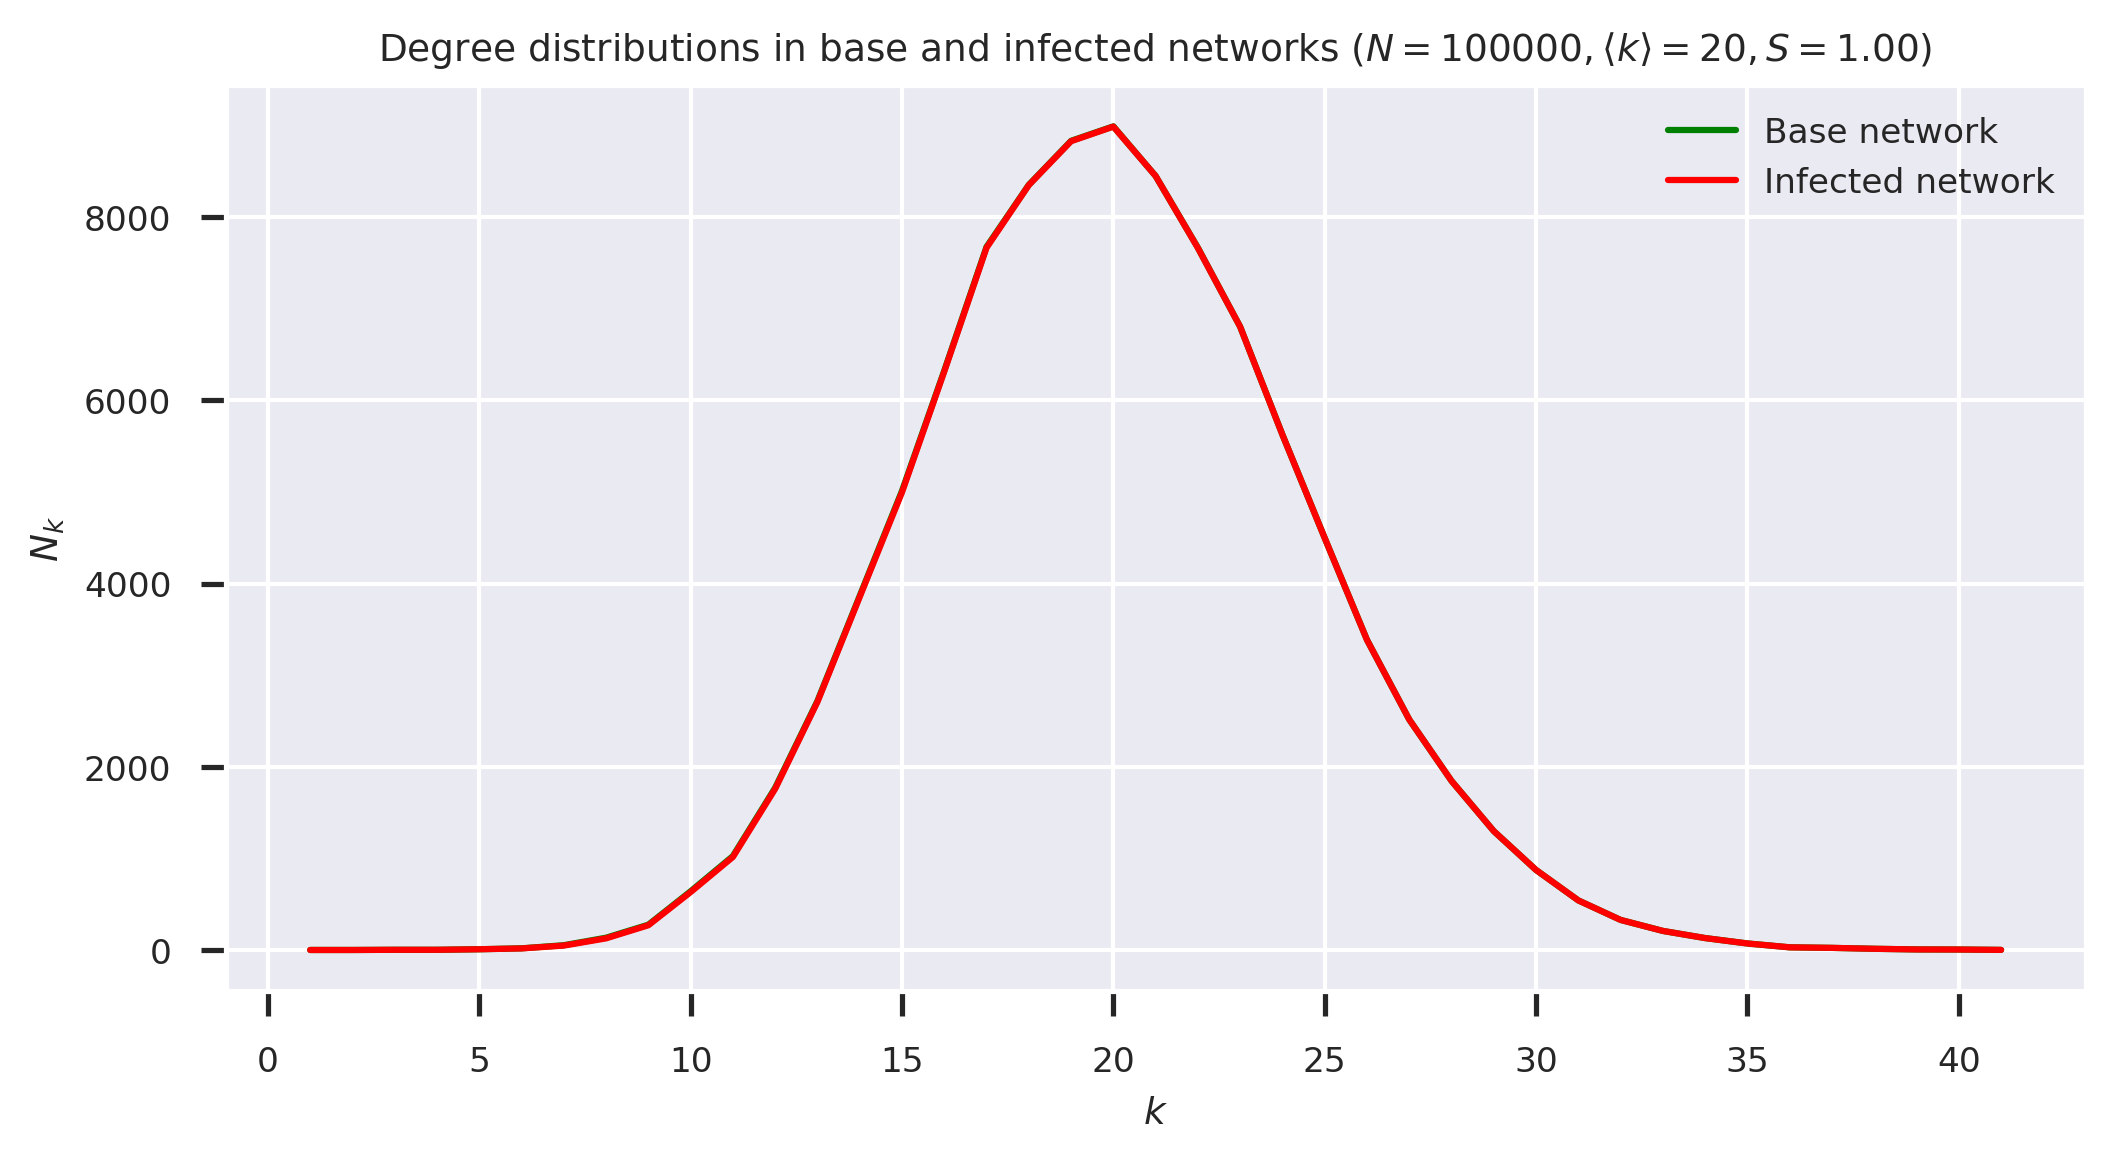

In [196]:
fig = plt.figure(figsize=(8, 4))

res = rc_er[Experiment.RESULTS]

s_er = res[SIRWithOrder.INFECTED_FRACTION]
                                
rawdegs = res[SIRWithOrder.DEGREE_DIST]
degs = res[SIRWithOrder.INFECTED_DEGREE_DIST]
kmax = max([max(degs), max(rawdegs)])
ks = list(range(kmax))

rawhist, _ = numpy.histogram(rawdegs, bins=range(kmax + 1))
plt.plot(ks[1:], rawhist[1:], 'g-', label='Base network')

hist, _ = numpy.histogram(degs, bins=range(kmax + 1))
plt.plot(ks[1:], hist[1:], 'r-', label='Infected network')

plt.xlabel('$k$')
plt.ylabel('$N_k$')
plt.legend(loc='upper right')
plt.title(f'Degree distributions in base and infected networks ($N = {N}, \\langle k \\rangle = {kmean}, S = {s_er:.2f}$)')

_ = plt.show()

In [163]:
pInfect = 0.2
pRemove = 0.002

alpha = 2.0
kappa = 40

In [164]:
params = dict()
params[SIR.P_INFECT] = 0.2
params[SIR.P_REMOVE] = pRemove
params[PLCNetwork.N] = N
params[PLCNetwork.EXPONENT] = alpha
params[PLCNetwork.CUTOFF] = kappa

e = StochasticDynamics(p, PLCNetwork())
rc_plc = e.set(params).run()

In [165]:
rc_plc

{'parameters': {'epydemic.SIR.pInfect': 0.2,
  'epydemic.SIR.pRemove': 0.002,
  'epydemic.generators.PLC.N': 100000,
  'epydemic.generators.PLC.exponent': 2.0,
  'epydemic.generators.PLC.cutoff': 40,
  'epydemic.SIR.pInfected': 0.0,
  'epydemic.generators.topology': 'PLC'},
 'metadata': {'epyc.experiment.classname': 'epydemic.stochasticdynamics.StochasticDynamics',
  'epyc.experiment.start_time': datetime.datetime(2021, 5, 26, 9, 4, 3, 82836),
  'epyc.experiment.setup_time': 184.454942,
  'epydemic.Dynamics.time': 6132.7560414899435,
  'epydemic.Dynamics.events': 155103,
  'epyc.experiment.experiment_time': 11.605464,
  'epyc.experiment.teardown_time': 0.046813,
  'epyc.experiment.end_time': datetime.datetime(2021, 5, 26, 9, 7, 19, 190055),
  'epyc.experiment.elapsed_time': 196.107219,
  'epyc.experiment.status': True},
 'results': {'epydemic.SIR.S': 22448,
  'epydemic.SIR.I': 0,
  'epydemic.SIR.R': 77552}}

In [168]:
g_plc = fn.finalNetwork()
attrs_plc = get_node_attributes(g_plc, SIRWithOrder.OCCUPIED)

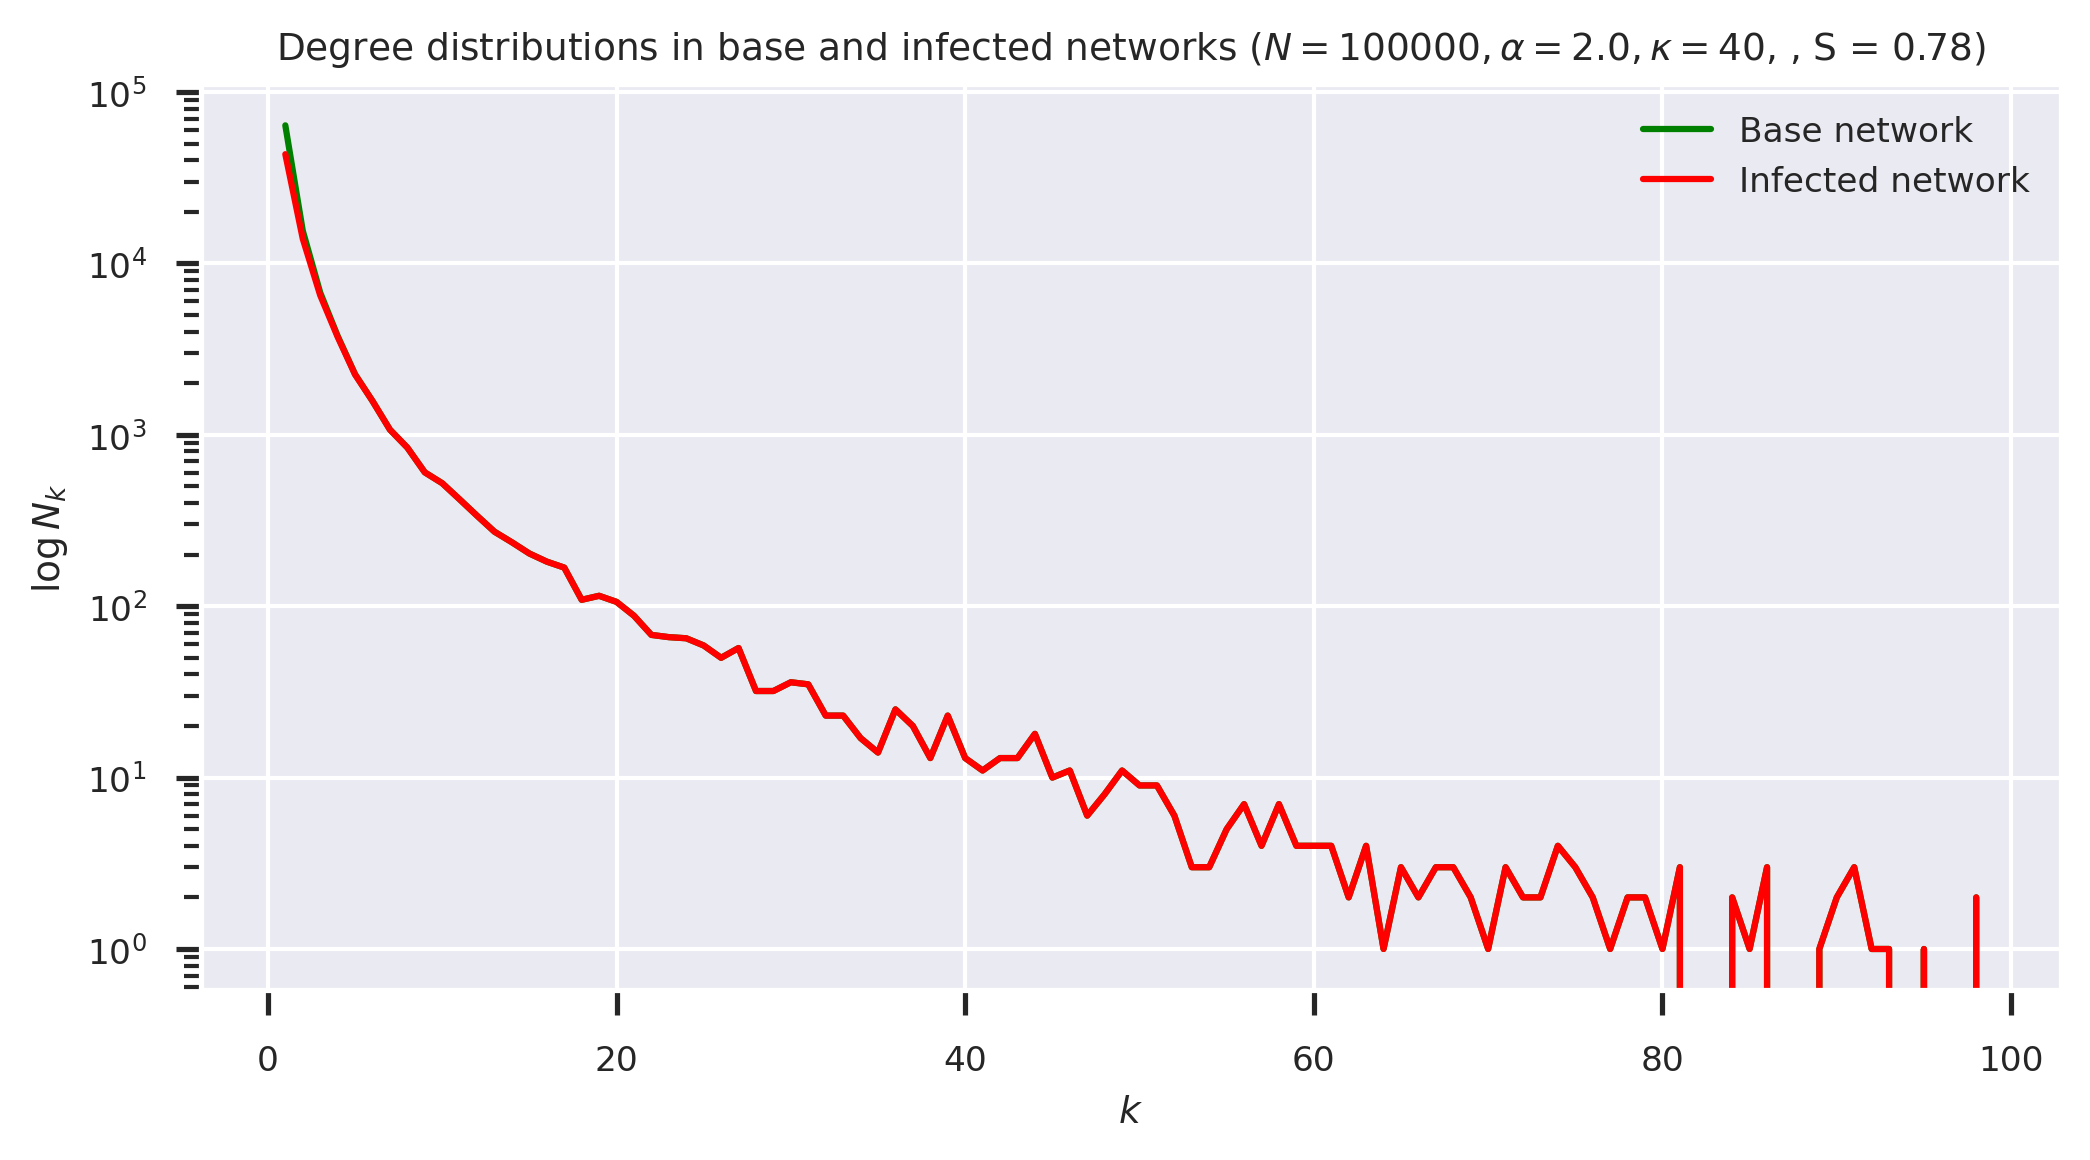

In [169]:
fig = plt.figure(figsize=(8, 4))

s_plc = rc_plc[Experiment.RESULTS][SIR.REMOVED] / g_plc.order()

rawdegs = list(degrees(g_plc, g_plc.nodes()))
degs = list(degrees(g_plc, orderOfOccupation(attrs_plc)))
kmax = max([max(degs), max(rawdegs)])
ks = list(range(kmax))

rawhist, _ = numpy.histogram(rawdegs, bins=range(kmax + 1))
plt.plot(ks[1:], rawhist[1:], 'g-', label='Base network')

hist, _ = numpy.histogram(degs, bins=range(kmax + 1))
plt.plot(ks[1:], hist[1:], 'r-', label='Infected network')

plt.xlabel('$k$')
plt.ylabel('$\\log N_k$')
plt.semilogy()
plt.legend(loc='upper right')
plt.title(f'Degree distributions in base and infected networks ($N = {N}, \\alpha = {alpha}, \\kappa = {kappa}$, , S = {s_plc:.2f})')

_ = plt.show()

In [114]:
hist

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 1])